# Infer EC50 values for the second replicate of the `171207_Eva1` chip

## Import `Python` modules

In [1]:
import os
import sys
import re
import glob

import xml.etree.ElementTree as ET
sys.path.append("/home/jupyter/tacc-work/jupyter_packages/lib/python2.7/site-packages")
from FlowCytometryTools import *

import numpy as np
import scipy.stats
import pandas
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(font_scale=1.5)

# Initialize directories
resultsdir = "results/171207_Eva1_rep2"
resultsdir_parse_metadata = os.path.join(resultsdir, 'parse_metadata')
dirs = [resultsdir, resultsdir_parse_metadata]
for dir_i in dirs:
    if not os.path.isdir(dir_i):
        os.makedirs(dir_i)

## Make the input experimental-summary file

### Specify all inputs

In [2]:
# Specify the location of FASTQ files
fastq_dir = '/work/05402/haddox/jupyter/sd2e-community/shared-q1-workshop/strcklnd/ngs_data/run_9/Run9_BIOFAB_EVA_chip1_E2/'
fastq_summary_file = '/work/05402/haddox/jupyter/sd2e-community/shared-q1-workshop/strcklnd/ngs_data/run_9/manifest.txt'

# Specify the locations of directories with FCS files with part of the FACS data
facs_dir = "/work/05402/haddox/jupyter/sd2e-community/shared-q1-workshop/strcklnd/facs_data/production_data/"
job_ids = ['Job_61955', 'Job_62383', 'Job_62947']
facs_dirs = ','.join([os.path.join(facs_dir, job_id) for job_id in job_ids])
job_ids = ','.join(job_ids)

# Specify the FACS channel name to investigate
facs_channel_name = u'FITC-A'

# Make a list of input XML files with the other part of the FACS data
xml_files = ','.join(glob.glob(
    os.path.join(facs_dir, 'sort_reports', '*/*.xml')
))

# Specify column-specific values to analyze in the metadata files.
library_name = "EVA_Chip1_Jan_2018"
ignore_aq_item_ids = '130281' # ignore the sequencing data for the (trypsin, 0) file

# Specify the output metadata CSV file
experimental_metadata_output_file = os.path.join(resultsdir_parse_metadata, 'experimental_metadata_from_script.csv')

# Read in input arguments, as if it were a new script
job_ids = job_ids.split(',')
facs_dirs = facs_dirs.split(',')
xml_files = xml_files.split(',')
ignore_aq_item_ids = ignore_aq_item_ids.split(',')

# Read in data on location of deep-sequencing data
fastq_df = pandas.read_csv(fastq_summary_file)

# Remove entires to ignore, as specified above
indices_to_drop = [i for (i, row) in fastq_df.iterrows() if str(row['aq_item_id']) in ignore_aq_item_ids]
fastq_df.drop(indices_to_drop, inplace=True)

# Piece together paths to FASTQ files and tweak some of entries to match
# expected patterns/cases
fastq_df['fastq_id'] = fastq_df.apply(lambda row: os.path.join(
    str(row['aq_item_id']), 'Files/'
), axis=1)
fastq_df['protease'] = fastq_df['protease'].apply(lambda x: x.lower())
fastq_df['strain'] = fastq_df['strain'].apply(lambda x: x.replace(' ', '_'))

# To conform with previous naming schemes, I will relabel the
# naive sample (naive, 0) to be the naive trypsin sample (trypsin, 0)
fastq_df['protease'] = fastq_df['protease'].apply(lambda x: x.replace('naive', 'trypsin'))

# Index by protease name and concentration
fastq_df.set_index(['protease', 'concentration'], inplace=True)

# Downsample to include only samples within library of interest
fastq_df = fastq_df[fastq_df['strain']==library_name]
fastq_df.sort_index(inplace=True)
fastq_df

aq_item_id  plan_id              strain  \
protease     concentration                                            
chymotrypsin 9.5                130282  12562.0  EVA_Chip1_Jan_2018   
             28.0               130283  12562.0  EVA_Chip1_Jan_2018   
             83.0               130288  12562.0  EVA_Chip1_Jan_2018   
             250.0              130286  12562.0  EVA_Chip1_Jan_2018   
             750.0              130290  12562.0  EVA_Chip1_Jan_2018   
             2250.0             130291  12562.0  EVA_Chip1_Jan_2018   
trypsin      0.0                130280      NaN  EVA_Chip1_Jan_2018   
             9.5                130284  12562.0  EVA_Chip1_Jan_2018   
             28.0               130285  12562.0  EVA_Chip1_Jan_2018   
             83.0               130287  12562.0  EVA_Chip1_Jan_2018   
             250.0              130289  12562.0  EVA_Chip1_Jan_2018   
             750.0              130292  12562.0  EVA_Chip1_Jan_2018   
             2250.0             130293  12562.0  EVA_Chip1_Jan_2018   

                                 fastq_id  
protease     concentration                 
chymotrypsin 9.5            130282/Files/  
             28.0           130283/Files/  
             83.0           130288/Files/  
             250.0          130286/Files/  
             750.0          130290/Files/  
             2250.0         130291/Files/  
trypsin      0.0            130280/Files/  
             9.5            130284/Files/  
             28.0           130285/Files/  
             83.0           130287/Files/  
             250.0          130289/Files/  
             750.0          130292/Files/  
             2250.0         130293/Files/

### For each sample in the experiment, quantify the total number of events and the number of events that passed the sorting threshold

In [3]:
def s_log(sample, channel_names):
    new_sample = sample.copy()
    new_data = new_sample.data

    for channel_name in channel_names:
        new_data[channel_name] = np.log10(new_data[channel_name])
        
    new_data.replace(to_replace = -np.inf, value = -1, inplace = True)
    new_data = new_data.dropna()
    new_sample.data = new_data
    
    return new_sample

In [4]:
# Read in data from the `manifest.txt` files
manifest_df = pandas.DataFrame()
for (job_id, facs_dir) in zip(job_ids, facs_dirs):
    df = pandas.read_csv(os.path.join(facs_dir, 'manifest.txt'))
    df['job_id'] = job_id
    df['directory'] = facs_dir
    df['specimen'] = df['filename'].apply(lambda x : x[:12])
    df['tube'] = df['filename'].apply(lambda x : x[13:21])
    df['strain'] = df['strain'].apply(lambda x: x.replace(' ', '_'))
    manifest_df = pandas.concat([manifest_df, df])
manifest_df.set_index(['job_id', 'specimen', 'tube'], inplace=True)

In [5]:
# Quantify the total number of events and events passing the gate
fitc_data_dict = {}
total_number_of_recorded_events = []
number_of_events_passing_fitc_gate = []
for (i, row) in manifest_df.iterrows():
    
    # Read in the data for the appropriate channel and transform it to a log10 scale
    fcs_file = os.path.join(row['directory'], row['filename'])
    sample = FCMeasurement(ID='Test Sample', datafile=fcs_file)
    #print("Analyzing the channel: {0}".format(channel_name))
    sample = s_log(sample, [facs_channel_name])
    df = sample.data
    
    # Count the number of total events and events passing the gate
    total_number_of_recorded_events.append(len(df.index.values))
    number_of_events_passing_fitc_gate.append(
        sum(df[facs_channel_name] > 3.0)
    )

# Append the FACS data to the manifest dataframe
manifest_df['total_number_of_recorded_events'] = total_number_of_recorded_events
manifest_df['number_of_events_passing_fitc_gate'] = number_of_events_passing_fitc_gate
manifest_df['fraction_collected'] = \
    manifest_df['number_of_events_passing_fitc_gate'] / manifest_df['total_number_of_recorded_events']
columns_to_show = [
    'strain', 'protease', 'concentration', 'total_number_of_recorded_events',
    'number_of_events_passing_fitc_gate', 'fraction_collected'
]
manifest_df = manifest_df[
    manifest_df['strain'] == library_name
]
manifest_df[columns_to_show]

/opt/conda/envs/python2/lib/python2.7/site-packages/ipykernel/__main__.py:6: RuntimeWarning: divide by zero encountered in log10
/opt/conda/envs/python2/lib/python2.7/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in log10


strain      protease  \
job_id    specimen     tube                                         
Job_61955 Specimen_001 Tube_006  EVA_Chip1_Jan_2018       trypsin   
                       Tube_007  EVA_Chip1_Jan_2018  chymotrypsin   
                       Tube_008  EVA_Chip1_Jan_2018  chymotrypsin   
                       Tube_009  EVA_Chip1_Jan_2018       trypsin   
                       Tube_010  EVA_Chip1_Jan_2018       trypsin   
Job_62383 Specimen_001 Tube_006  EVA_Chip1_Jan_2018  chymotrypsin   
                       Tube_008  EVA_Chip1_Jan_2018  chymotrypsin   
                       Tube_009  EVA_Chip1_Jan_2018  chymotrypsin   
                       Tube_007  EVA_Chip1_Jan_2018       trypsin   
                       Tube_010  EVA_Chip1_Jan_2018       trypsin   
                       Tube_011  EVA_Chip1_Jan_2018       trypsin   
Job_62947 Specimen_001 Tube_006  EVA_Chip1_Jan_2018  chymotrypsin   
                       Tube_008  EVA_Chip1_Jan_2018  chymotrypsin   
                       Tube_009  EVA_Chip1_Jan_2018  chymotrypsin   
                       Tube_007  EVA_Chip1_Jan_2018       trypsin   
                       Tube_010  EVA_Chip1_Jan_2018       trypsin   
                       Tube_011  EVA_Chip1_Jan_2018       trypsin   

                                 concentration  \
job_id    specimen     tube                      
Job_61955 Specimen_001 Tube_006            0.0   
                       Tube_007            9.5   
                       Tube_008           28.0   
                       Tube_009            9.5   
                       Tube_010           28.0   
Job_62383 Specimen_001 Tube_006            0.0   
                       Tube_008           83.0   
                       Tube_009          250.0   
                       Tube_007            0.0   
                       Tube_010           83.0   
                       Tube_011          250.0   
Job_62947 Specimen_001 Tube_006            0.0   
                       Tube_008          750.0   
                       Tube_009         2250.0   
                       Tube_007            0.0   
                       Tube_010          750.0   
                       Tube_011         2250.0   

                                 total_number_of_recorded_events  \
job_id    specimen     tube                                        
Job_61955 Specimen_001 Tube_006                            29997   
                       Tube_007                            29995   
                       Tube_008                            29994   
                       Tube_009                            29985   
                       Tube_010                            29987   
Job_62383 Specimen_001 Tube_006                            29996   
                       Tube_008                            29998   
                       Tube_009                            29995   
                       Tube_007                            29992   
                       Tube_010                            29993   
                       Tube_011                            29996   
Job_62947 Specimen_001 Tube_006                            29994   
                       Tube_008                            29996   
                       Tube_009                            29998   
                       Tube_007                            29995   
                       Tube_010                            29991   
                       Tube_011                            29991   

                                 number_of_events_passing_fitc_gate  \
job_id    specimen     tube                                           
Job_61955 Specimen_001 Tube_006                                8266   
                       Tube_007                                7079   
                       Tube_008                                6300   
                       Tube_009                                6238   
                       Tube_010                                

Go through the dataframe, making a list of samples to drop. Specifically, I will drop naive samples that are not from the first day of sorting. But, before doing so, I will record data from them to include in the `parent_expression` column of the output file.

In [6]:
map_job_id_to_sort_round = {
    'Job_61955' : 1, 'Job_62383' : 2, 'Job_62947' : 3
}
naive_sample_expression = {'trypsin':{}, 'chymotrypsin':{}}
list_of_indices_to_drop = []

for (i, row) in manifest_df.iterrows():
    (job_id, specimen, tube) = i
    sort_round = map_job_id_to_sort_round[job_id]
    if row['concentration'] == 0.0:
        naive_sample_expression[row['protease']][sort_round] = row['fraction_collected']
        if sort_round != 1:
            list_of_indices_to_drop.append(i)
            
manifest_df.drop(list_of_indices_to_drop, axis='index', inplace=True)
manifest_df[columns_to_show]

strain      protease  \
job_id    specimen     tube                                         
Job_61955 Specimen_001 Tube_006  EVA_Chip1_Jan_2018       trypsin   
                       Tube_007  EVA_Chip1_Jan_2018  chymotrypsin   
                       Tube_008  EVA_Chip1_Jan_2018  chymotrypsin   
                       Tube_009  EVA_Chip1_Jan_2018       trypsin   
                       Tube_010  EVA_Chip1_Jan_2018       trypsin   
Job_62383 Specimen_001 Tube_008  EVA_Chip1_Jan_2018  chymotrypsin   
                       Tube_009  EVA_Chip1_Jan_2018  chymotrypsin   
                       Tube_010  EVA_Chip1_Jan_2018       trypsin   
                       Tube_011  EVA_Chip1_Jan_2018       trypsin   
Job_62947 Specimen_001 Tube_008  EVA_Chip1_Jan_2018  chymotrypsin   
                       Tube_009  EVA_Chip1_Jan_2018  chymotrypsin   
                       Tube_010  EVA_Chip1_Jan_2018       trypsin   
                       Tube_011  EVA_Chip1_Jan_2018       trypsin   

                                 concentration  \
job_id    specimen     tube                      
Job_61955 Specimen_001 Tube_006            0.0   
                       Tube_007            9.5   
                       Tube_008           28.0   
                       Tube_009            9.5   
                       Tube_010           28.0   
Job_62383 Specimen_001 Tube_008           83.0   
                       Tube_009          250.0   
                       Tube_010           83.0   
                       Tube_011          250.0   
Job_62947 Specimen_001 Tube_008          750.0   
                       Tube_009         2250.0   
                       Tube_010          750.0   
                       Tube_011         2250.0   

                                 total_number_of_recorded_events  \
job_id    specimen     tube                                        
Job_61955 Specimen_001 Tube_006                            29997   
                       Tube_007                            29995   
                       Tube_008                            29994   
                       Tube_009                            29985   
                       Tube_010                            29987   
Job_62383 Specimen_001 Tube_008                            29998   
                       Tube_009                            29995   
                       Tube_010                            29993   
                       Tube_011                            29996   
Job_62947 Specimen_001 Tube_008                            29996   
                       Tube_009                            29998   
                       Tube_010                            29991   
                       Tube_011                            29991   

                                 number_of_events_passing_fitc_gate  \
job_id    specimen     tube                                           
Job_61955 Specimen_001 Tube_006                                8266   
                       Tube_007                                7079   
                       Tube_008                                6300   
                       Tube_009                                6238   
                       Tube_010                                3833   
Job_62383 Specimen_001 Tube_008                               10574   
                       Tube_009                                5030   
                       Tube_010                                6909   
                       Tube_011                                3744   
Job_62947 Specimen_001 Tube_008                                5420   
                       Tube_009                                2211   
                       Tube_010                                4710   
                       Tube_011                                2059   

                                 fraction_collected  
job_id    specimen     tube                          
Job_61955 Specimen_001 Tube_006            0.275561  
         

Read in data from the XML files on the total number of cells collected. There is a single XML file with this information for each individual sample in the experiment. The XML files are not named in a way that is easy to get relevant sample info. But this info can be extracted from the files. So, I will read in all XML files that the BIOFAB has uploaded, even ones that aren't relevant to this experiment, and then identify the relevant ones using the `job_id`, `specimen`, and `tube` columns.

In [7]:
# Compile data in each XML file
xml_data_dict = {
    key : []
    for key in ['job_id', 'specimen', 'tube', 'cells_collected', 'intended_number_of_cells_collected', 'xmlfile'] #
}
cells_collected_pattern = re.compile(r'\w+ : (?P<cells_collected>\d+) / (?P<intended_number_of_cells_collected>\d+)')
for filename in xml_files:
    tree = ET.parse(filename)
    root = tree.getroot()

    # Get experiment metadata
    xml_data_dict['job_id'].append( root.findall(".//*[@name='Experiment']")[0].get('value') )
    xml_data_dict['specimen'].append( root.findall(".//*[@name='Specimen']")[0].get('value') )
    xml_data_dict['tube'].append( root.findall(".//*[@name='Tube']")[0].get('value') )
    xml_data_dict['xmlfile'].append(filename)
    
    # Get experiment counts
    cells_collected_data = root[4].findall(".//*[@col='1']")[0].text
    match = re.match(cells_collected_pattern, cells_collected_data)
    if match:
        xml_data_dict['cells_collected'].append(
            int(match.group('cells_collected'))
        )
        xml_data_dict['intended_number_of_cells_collected'].append(
            int(match.group('intended_number_of_cells_collected'))
        )
    else:
        xml_data_dict['cells_collected'].append(None)
        xml_data_dict['intended_number_of_cells_collected'].append(None)
          
# Convert data to a dataframe
xml_data_df = pandas.DataFrame.from_dict(xml_data_dict)
xml_data_df.set_index(['job_id', 'specimen', 'tube'], inplace=True)
#xml_data_df

Merge the FACS data from the two input sources

In [8]:
facs_df = manifest_df.merge(xml_data_df, left_index=True, right_index=True, how='left')
facs_df = facs_df[
    facs_df['strain'] == library_name
]
facs_df.set_index(['protease', 'concentration'], inplace=True, drop=False)
columns_to_show = ['cells_collected', 'fraction_collected']
facs_df[columns_to_show].sort_index()

cells_collected  fraction_collected
protease     concentration                                     
chymotrypsin 9.5                  2844000.0            0.236006
             28.0                       NaN            0.210042
             83.0                 4272000.0            0.352490
             250.0                2040000.0            0.167695
             750.0                2220000.0            0.180691
             2250.0                924000.0            0.073705
trypsin      0.0                  3323999.0            0.275561
             9.5                        NaN            0.208037
             28.0                       NaN            0.127822
             83.0                 2796000.0            0.230354
             250.0                1512000.0            0.124817
             750.0                1735829.0            0.157047
             2250.0                851999.0            0.068654

Merge the FACS and deep-sequencing data

In [9]:
df = fastq_df.merge(facs_df, left_index=True, right_index=True, how="outer")
columns_to_write = ['fastq_id', 'cells_collected', 'fraction_collected']
df = df[columns_to_write]
df.reset_index(inplace=True)
df

,protease,concentration,fastq_id,cells_collected,fraction_collected
0,chymotrypsin,9.5,130282/Files/,2844000.0,0.236006
1,chymotrypsin,28.0,130283/Files/,NaN,0.210042
2,chymotrypsin,83.0,130288/Files/,4272000.0,0.352490
3,chymotrypsin,250.0,130286/Files/,2040000.0,0.167695
4,chymotrypsin,750.0,130290/Files/,2220000.0,0.180691
5,chymotrypsin,2250.0,130291/Files/,924000.0,0.073705
6,trypsin,0.0,130280/Files/,3323999.0,0.275561
7,trypsin,9.5,130284/Files/,NaN,0.208037
8,trypsin,28.0,130285/Files/,NaN,0.127822
9,trypsin,83.0,130287/Files/,2796000.0,0.230354


Add a row for a naive sample for chymotrypsin, using the same deep-sequencing data as for trypsin 

In [10]:
df_with_extra_row = pandas.DataFrame.from_dict(
    {
        'protease' : ['chymotrypsin'],
        'concentration' : [0],
        'fastq_id' : [df.iloc[6]['fastq_id']],
        'cells_collected' : [df.iloc[6]['cells_collected']],
        'fraction_collected' : [df.iloc[6]['fraction_collected']]
    }
)
df_with_extra_row
df = pandas.concat([df, df_with_extra_row])

Show concatenated dataframe, sorted by protease and protease concentration.

In [11]:
df.sort_values(by=['protease', 'concentration'], inplace=True)
df

,cells_collected,concentration,fastq_id,fraction_collected,protease
0,3323999.0,0.0,130280/Files/,0.275561,chymotrypsin
0,2844000.0,9.5,130282/Files/,0.236006,chymotrypsin
1,NaN,28.0,130283/Files/,0.210042,chymotrypsin
2,4272000.0,83.0,130288/Files/,0.352490,chymotrypsin
3,2040000.0,250.0,130286/Files/,0.167695,chymotrypsin
4,2220000.0,750.0,130290/Files/,0.180691,chymotrypsin
5,924000.0,2250.0,130291/Files/,0.073705,chymotrypsin
6,3323999.0,0.0,130280/Files/,0.275561,trypsin
7,NaN,9.5,130284/Files/,0.208037,trypsin
8,NaN,28.0,130285/Files/,0.127822,trypsin


Manually add missing columns

In [12]:
# Add columns
df['experiment_id'] = library_name
df['selection_strength'] = 2 * [i for i in range(0,7)]
df['conc_factor'] = 2 * ['', '3', '3', '3', '3', '3', '3']
df['parent'] = 2 * ['', '0', '0', '2', '2', '4', '4']

Add the row called `parent_expression`, which reports the fraction of collected cells (i.e., passed the selection threshold) in a naive sample that was ***not*** treated with protease and which was sorted on the same day as protease-treated samples.

In [13]:
# Make a dictionary to map protease concentration to sort round
map_protease_conc_to_sort_round = {
    0.0 : 1,
    9.5 : 1,
    28.0 : 1,
    83.0 : 2,
    250.0 : 2,
    750.0 : 3,
    2250.0 : 3
}

# Add a `parent_expression` column to the dataframe. Use the same value for
# all protease-treated samples from the first sort round, regardless of protease.
# This value is derived from (trypsin, 0), but is relative to both proteases
# since it is naive sample. Add blank entires for the naive samples from the first
# sort.
parent_expression_list = []
for (i, row) in df.iterrows():
    protease = row['protease']
    concentration = row['concentration']
    sort_round = map_protease_conc_to_sort_round[concentration]
    if concentration == 0.0:
        parent_expression_list.append('')
    elif (protease, sort_round) == ('chymotrypsin', 1):
        parent_expression_list.append(naive_sample_expression['trypsin'][sort_round])
    else:
        parent_expression_list.append(naive_sample_expression[protease][sort_round])
df['parent_expression'] = parent_expression_list
df

,cells_collected,concentration,fastq_id,fraction_collected,protease,experiment_id,selection_strength,conc_factor,parent,parent_expression
0,3323999.0,0.0,130280/Files/,0.275561,chymotrypsin,EVA_Chip1_Jan_2018,0,,,
0,2844000.0,9.5,130282/Files/,0.236006,chymotrypsin,EVA_Chip1_Jan_2018,1,3,0,0.275561
1,NaN,28.0,130283/Files/,0.210042,chymotrypsin,EVA_Chip1_Jan_2018,2,3,0,0.275561
2,4272000.0,83.0,130288/Files/,0.352490,chymotrypsin,EVA_Chip1_Jan_2018,3,3,2,0.557808
3,2040000.0,250.0,130286/Files/,0.167695,chymotrypsin,EVA_Chip1_Jan_2018,4,3,2,0.557808
4,2220000.0,750.0,130290/Files/,0.180691,chymotrypsin,EVA_Chip1_Jan_2018,5,3,4,0.677269
5,924000.0,2250.0,130291/Files/,0.073705,chymotrypsin,EVA_Chip1_Jan_2018,6,3,4,0.677269
6,3323999.0,0.0,130280/Files/,0.275561,trypsin,EVA_Chip1_Jan_2018,0,,,
7,NaN,9.5,130284/Files/,0.208037,trypsin,EVA_Chip1_Jan_2018,1,3,0,0.275561
8,NaN,28.0,130285/Files/,0.127822,trypsin,EVA_Chip1_Jan_2018,2,3,0,0.275561


Rename columns and show the final dataframe.

In [14]:
# Rename columns
df.rename(
    {'protease':'protease_type'},
    inplace=True,
    axis='columns'
)
column_order = [
    'experiment_id', 'protease_type', 'concentration', 'selection_strength', 'parent', 'conc_factor', 'fastq_id',
    'parent_expression', 'fraction_collected', 'cells_collected'
]
df[column_order]

,experiment_id,protease_type,concentration,selection_strength,parent,conc_factor,fastq_id,parent_expression,fraction_collected,cells_collected
0,EVA_Chip1_Jan_2018,chymotrypsin,0.0,0,,,130280/Files/,,0.275561,3323999.0
0,EVA_Chip1_Jan_2018,chymotrypsin,9.5,1,0,3,130282/Files/,0.275561,0.236006,2844000.0
1,EVA_Chip1_Jan_2018,chymotrypsin,28.0,2,0,3,130283/Files/,0.275561,0.210042,NaN
2,EVA_Chip1_Jan_2018,chymotrypsin,83.0,3,2,3,130288/Files/,0.557808,0.352490,4272000.0
3,EVA_Chip1_Jan_2018,chymotrypsin,250.0,4,2,3,130286/Files/,0.557808,0.167695,2040000.0
4,EVA_Chip1_Jan_2018,chymotrypsin,750.0,5,4,3,130290/Files/,0.677269,0.180691,2220000.0
5,EVA_Chip1_Jan_2018,chymotrypsin,2250.0,6,4,3,130291/Files/,0.677269,0.073705,924000.0
6,EVA_Chip1_Jan_2018,trypsin,0.0,0,,,130280/Files/,,0.275561,3323999.0
7,EVA_Chip1_Jan_2018,trypsin,9.5,1,0,3,130284/Files/,0.275561,0.208037,NaN
8,EVA_Chip1_Jan_2018,trypsin,28.0,2,0,3,130285/Files/,0.275561,0.127822,NaN


Write the above dataframe to an output file

In [15]:
print("Writing metadata to the experimental summary file: {0}".format(experimental_metadata_output_file))
df[column_order].to_csv(experimental_metadata_output_file, index=False)

Writing metadata to the experimental summary file: results/171207_Eva1_rep2/parse_metadata/experimental_metadata_from_script.csv


## Compute EC50 values from the input deep-sequencing and FACS data

In [2]:
# Define input variables
data_dir = 'data/171207_Eva1/'
designed_sequences_file = os.path.join(data_dir, 'designed_sequences_eva1.csv')
experimental_summary_file = os.path.join(experimental_metadata_output_file)
fastq_dir = fastq_dir
pear_path = '/home/05402/haddox/software/pear/bin/pear'
output_dir = resultsdir

NameError: name 'experimental_metadata_output_file' is not defined

In [17]:
# Write the command to carry everything out
cmd = ' '.join([
    'python',
    'scripts/compute_ec50_values_from_deep_sequencing_data.py',
    '--designed_sequences_file {0}'.format(designed_sequences_file),
    '--experimental_summary_file {0}'.format(experimental_summary_file),
    '--fastq_dir {0}'.format(fastq_dir),
    '--pear_path {0}'.format(pear_path),
    '--output_dir {0}'.format(output_dir)
])

#! {cmd}
print(cmd)

python scripts/compute_ec50_values_from_deep_sequencing_data.py --designed_sequences_file data/171207_Eva1/designed_sequences_eva1.csv --experimental_summary_file results/171207_Eva1_rep2/parse_metadata/experimental_metadata_from_script.csv --fastq_dir /work/05402/haddox/jupyter/sd2e-community/shared-q1-workshop/strcklnd/ngs_data/run_9/Run9_BIOFAB_EVA_chip1_E2/ --pear_path /home/05402/haddox/software/pear/bin/pear --output_dir results/171207_Eva1_rep2


## Analyze the data

In [3]:
sns.set(font_scale=2)
sns.set_style("ticks")

Quantify the number of assembled reads per sample

Problem parsint the file: results/171207_Eva1_rep2/paired_FASTQ_files/trypsin_0-3.log
Problem parsint the file: results/171207_Eva1_rep2/paired_FASTQ_files/chymotrypsin_0-3.log


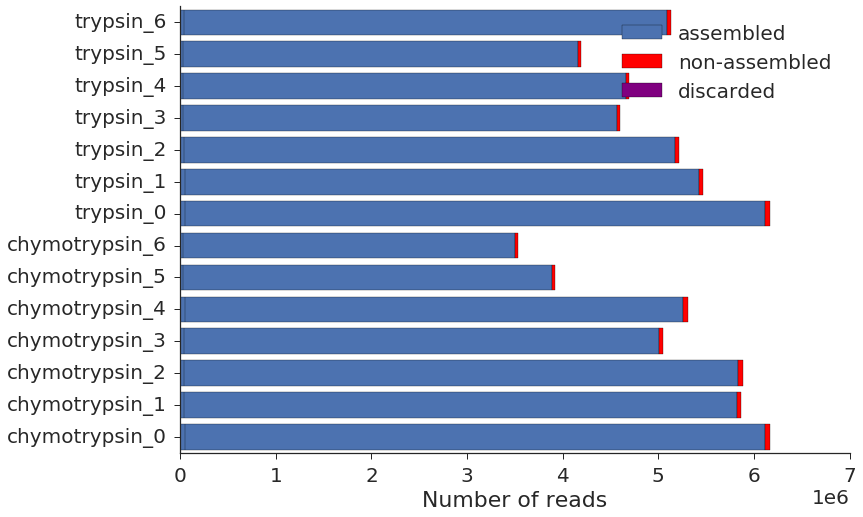

In [10]:
def ParsePAREOutfile(outfile):
    """
    This function parses the output data generated by PARE when assemblying paired-end reads
    
    Args:
        `outfile`: the path to a file with the output data generated by PARE
        
    Returns:
        A tupple with the following three variables in the order they appear in the below list:
            `n_assembled_reads` : the total number of assembled reads
            `n_discarded_reads` : the total number of discarded reads
            `n_non_assembled_reads` : the total number of non_assembled_reads
    """
    
    # Pattern used to extract data
    n_reads_pattern = re.compile(r'\: (?P<n_reads>[\d,]+) /')
    
    # Use regular expressions to extract the relevant info from the file
    n_assembled_reads = n_discarded_reads = n_non_assembled_reads = n_total_reads = None
    with open(outfile) as f:
        #print(f.readlines())
        for line in f:
            if 'Assembled reads .' in line:
                if n_assembled_reads:
                    raise ValueError("Already found data for `n_assembled_reads`")
                n_assembled_match = re.search(n_reads_pattern, line)
                n_assembled_reads = int(n_assembled_match.group('n_reads').replace(',', ''))
                
            elif 'Discarded reads .' in line:
                if n_discarded_reads:
                    raise ValueError("Already found data for `n_discarded_reads`")
                n_discarded_match = re.search(n_reads_pattern, line)
                n_discarded_reads = int(n_discarded_match.group('n_reads').replace(',', ''))
                
            elif 'Not assembled reads .' in line:
                if n_non_assembled_reads:
                    raise ValueError("Already found data for `n_non_assembled_reads`")
                n_non_assembled_match = re.search(n_reads_pattern, line)
                n_non_assembled_reads = int(n_non_assembled_match.group('n_reads').replace(',', ''))
    
    return (n_assembled_reads, n_discarded_reads, n_non_assembled_reads)

# Find log files from PARE
pare_log_dir = os.path.join(resultsdir, 'paired_FASTQ_files')

selection_indices = list(range(0,7))
experiment_names = ['trypsin_{0}'.format(i) for i in selection_indices] + \
    ['chymotrypsin_{0}'.format(i) for i in selection_indices]
log_files = glob.glob(os.path.join(pare_log_dir, '*.log'))
log_files_dict = {
    experiment_name : []
    for experiment_name in experiment_names
}
# For each log file, look for an experimental name that matches the beginning
# of the base name of the log file
for log_file_name in log_files:
    matching_experiments = []
    for experiment_name in log_files_dict:
        log_file_basename = os.path.basename(log_file_name)
        if log_file_basename.find('{0}-'.format(experiment_name)) == 0:
            log_files_dict[experiment_name].append(log_file_name)
            matching_experiments.append(experiment_name)
    if len(matching_experiments) == 0:
        raise ValueError("Could not find a matching experiment for the log file: {0}".format(log_file_name))
    if len(matching_experiments) > 1:
        print(matching_experiments)
        raise ValueError("Found multiple matching experiments for the log file: {0}".format(log_file_name))
    assert len(matching_experiments) == 1
    
# Read in depth and quality scores from the output of the `PEAR` program and store in a pandas dataframe
assembly_d = {
    key : []
    for key in ['experiment_name', 'n_assembled_reads', 'n_discarded_reads', 'n_non_assembled_reads']
}
for experiment_name in log_files_dict:
    assembly_d['experiment_name'].append(experiment_name)
    n_assembled_reads = n_discarded_reads = n_non_assembled_reads = 0
    for log_file_name in log_files_dict[experiment_name]:
        (n_assembled_reads_i, n_discarded_reads_i, n_non_assembled_reads_i) = \
            ParsePAREOutfile(log_file_name)
        try:
            n_assembled_reads += n_assembled_reads_i
            n_discarded_reads += n_discarded_reads_i
            n_non_assembled_reads += n_non_assembled_reads_i
        except TypeError:
            print("Problem parsing the file: {0}".format(log_file_name))
            continue #raise TypeError("There was a problem with the file: {0}".format(log_file_name))
    assembly_d['n_assembled_reads'].append(n_assembled_reads)
    assembly_d['n_discarded_reads'].append(n_discarded_reads)
    assembly_d['n_non_assembled_reads'].append(n_non_assembled_reads)

assembly_df = pandas.DataFrame.from_dict(assembly_d)

# Plot the data for each replicate as stacked bar charts
fig = plt.figure(figsize=(12,8))

# Get data for each bar
assembly_df.set_index('experiment_name', inplace=True)
labels = sorted(assembly_df.index.values)
first_bar = assembly_df.loc[labels]['n_assembled_reads']
second_bar = assembly_df.loc[labels]['n_non_assembled_reads']
third_bar = assembly_df.loc[labels]['n_discarded_reads']
assert(len(first_bar) == len(second_bar))

# Make plot
plot_indices = np.arange(len(first_bar))
width = 0.35
plt.barh(plot_indices, first_bar, label='assembled', align='center')
plt.barh(plot_indices, second_bar, left=first_bar, label='non-assembled', color='red', align='center')
plt.barh(plot_indices, third_bar, left=second_bar, label='discarded', color='purple', align='center')
plt.yticks(plot_indices, labels)
plt.xlabel('Number of reads')
plt.legend()
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
def adjust_ylim(l):
    mn, mx = l
    mn += 1.5
    mx -= .5
    return (mn, mx)
plt.ylim(adjust_ylim(plt.ylim()))
plt.yticks()
sns.despine()

Look at QC measures for counts

(20027, 20027, 20027)
Plotting data for t


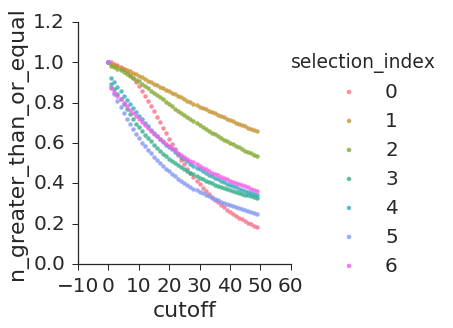

Plotting data for c


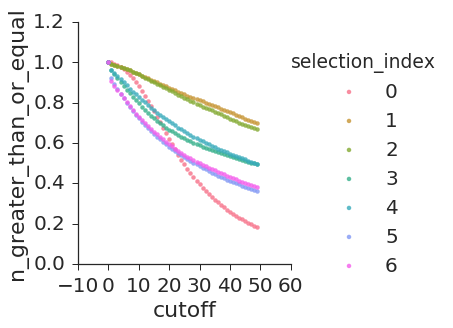

In [11]:
# Read in counts from files
df_t = pandas.read_csv(os.path.join(resultsdir, 'counts/trypsin.counts'), sep=' ')
df_t.set_index('name', inplace=True)
df_c = pandas.read_csv(os.path.join(resultsdir, 'counts/chymotrypsin.counts'), sep=' ')
df_c.set_index('name', inplace=True)
counts_df = df_t.merge(
    df_c,
    left_index=True,
    right_index=True,
    how='outer',
    suffixes =['_t', '_c'])
print(len(counts_df), len(df_t), len(df_c))
#counts_df

# Make a dataframe with data on the number of designs with counts greater than a given
# cutoff
counts_data_columns = ['protease', 'selection_index', 'cutoff', 'n_greater_than_or_equal']
counts_data_dict = {
    key : []
    for key in counts_data_columns
}
cutoffs = np.arange(0,50,1)
selection_indices = list(range(0,7))
for protease in ['c', 't']:
    for selection_index in selection_indices:
        counts = counts_df['counts{0}_{1}'.format(selection_index, protease)]
        for cutoff in cutoffs:
            n_greater_than_or_equal = sum(counts >= cutoff)/float(len(counts))
            
            counts_data_dict['protease'].append(protease)
            counts_data_dict['selection_index'].append(selection_index)
            counts_data_dict['cutoff'].append(cutoff)
            counts_data_dict['n_greater_than_or_equal'].append(n_greater_than_or_equal)

counts_data_df = pandas.DataFrame.from_dict(counts_data_dict)        
#counts_data_df

# Plot the data
for protease in ['t', 'c']:
    print("Plotting data for {0}".format(protease))
    data = counts_data_df[counts_data_df['protease']==protease]
    sns.lmplot(
        x="cutoff",
        y="n_greater_than_or_equal",
        data=data,
        hue='selection_index',
        fit_reg=False
    )
    plt.show()

Make a dataframe showing the number of unique sequences at each stage of the experiment

In [12]:
counts_data_columns = [
    'protease', 'selection_index', 'n_unique_sequences',
    'median_counts', 'median_frequency', 'entropy'
]
counts_data_dict = {
    key : []
    for key in counts_data_columns
}
selection_indices = list(range(0,7))
for protease in ['c', 't']:
    for selection_index in selection_indices:
        counts = counts_df['counts{0}_{1}'.format(selection_index, protease)].values
        total_counts = sum(counts)
        frequencies = counts / total_counts
        assert 1-sum(frequencies) < 1e-5
        
        n_unique_sequences = sum(counts > 0)
        entropy = scipy.stats.entropy(frequencies)
        median_counts = np.median(counts)
        median_frequency = np.median(frequencies)
        
        counts_data_dict['protease'].append(protease)
        counts_data_dict['selection_index'].append(selection_index)
        counts_data_dict['n_unique_sequences'].append(n_unique_sequences)
        counts_data_dict['entropy'].append(entropy)
        counts_data_dict['median_counts'].append(median_counts)
        counts_data_dict['median_frequency'].append(median_frequency)
        
counts_data_df = pandas.DataFrame.from_dict(counts_data_dict)
counts_data_df[counts_data_columns]

,protease,selection_index,n_unique_sequences,median_counts,median_frequency,entropy
0,c,0,20027,24.0,0.000035,9.537589
1,c,1,19875,86.0,0.000031,9.351201
2,c,2,19908,82.0,0.000029,9.288790
3,c,3,19296,47.0,0.000017,8.936024
4,c,4,19324,48.0,0.000017,8.876182
5,c,5,18497,28.0,0.000013,8.586624
6,c,6,18196,29.0,0.000015,8.790455
7,t,0,20027,24.0,0.000035,9.537589
8,t,1,19886,79.0,0.000030,9.310012
9,t,2,19721,54.0,0.000025,9.183998


Read in the stability scores for each protease and make a single dataframe with data from each, with suffixes of `_t` or `_c` indicating that the data is derived from trypsin or chymotrypsin, respectively.

In [13]:
# Read in data for each protease, making the `name` column the index
# in each case
trypsin_df = pandas.read_csv(
    os.path.join(resultsdir, 'stability_scores/trypsin_stability_scores.txt'), sep='\t'
)
chymotrypsin_df = pandas.read_csv(
    os.path.join(resultsdir, 'stability_scores/chymotrypsin_stability_scores.txt'), sep='\t'
)
trypsin_df.set_index('name', inplace=True)
chymotrypsin_df.set_index('name', inplace=True)

# Merge the dataframes, using `_t` and `_c` as suffixes to indicate
# which data is from trypsin and chymotrypsin, respectively
stability_scores_df = trypsin_df.merge(
    chymotrypsin_df,
    left_index=True,
    right_index=True,
    how='outer',
    suffixes=['_t', '_c']
)
stability_scores_df['stabilityscore'] = stability_scores_df.apply(
    lambda row: min(row['stabilityscore_t'], row['stabilityscore_c']), axis=1
)
stability_scores_outfile = os.path.join(resultsdir, 'stability_scores/stability_scores.txt')
print("Writing merged stability scores to the file: {0}".format(stability_scores_outfile))
stability_scores_df.to_csv(stability_scores_outfile, sep='\t')

Writing merged stability scores to the file: results/171207_Eva1_rep2/stability_scores/stability_scores.txt


### Analyze the quality of the EC50 estimates, filtering those with 95% credible intervals below 2 EC50 units.

Look at the distribution of 95% CIs

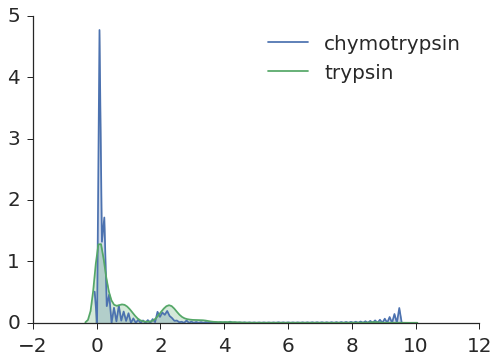

In [14]:
sns.kdeplot(stability_scores_df['ec50_95ci_c'], label='chymotrypsin', shade=True)
sns.kdeplot(stability_scores_df['ec50_95ci_t'], label='trypsin', shade=True)
sns.despine()

Show the distribution of EC50 95% CIs relative to the matching EC50 values.

Plot for t


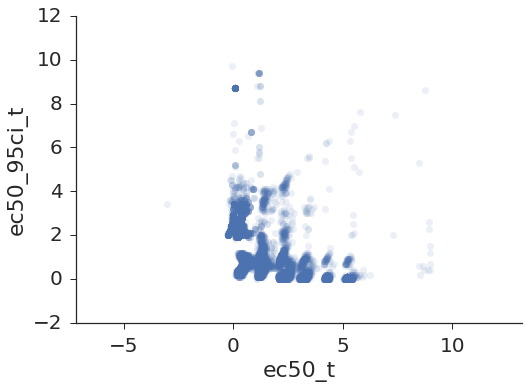

Plot for c


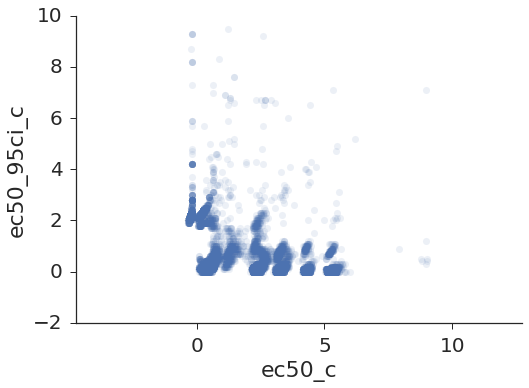

In [15]:
for protease in ['t', 'c']:
    print("Plot for {0}".format(protease))
    sns.regplot(
        x='ec50_{0}'.format(protease),
        y='ec50_95ci_{0}'.format(protease),
        data=stability_scores_df,
        scatter_kws={'alpha':0.1, 's':50},
        fit_reg=False
    )
    sns.despine()
    plt.axis('equal')
    plt.show()

Filter out designs where the 95% CI is greater than two EC50 units, as Gabe did in his paper.

In [16]:
# Find sequences where the EC50 CI is greater than two EC50 units
cutoff = 2
high_confidence_seqs_bools = \
    (stability_scores_df['ec50_95ci_t'] < cutoff) & \
    (stability_scores_df['ec50_95ci_c'] < cutoff)
    
# Find stable sequences, as defined by stability scores > 1
stability_cutoff = 1
stable_seqs_bools = stability_scores_df['stabilityscore'] > stability_cutoff

# Make a list of stable sequences that passed the CI-based filtering step
print("The total number of sequences is: {0}".format(len(stability_scores_df)))
print("The number of stable sequences is: {0}".format(sum(stable_seqs_bools)))
print("The number of sequences with high-confidence stability scores is: {0}".format(sum(high_confidence_seqs_bools)))
print("The number of stable, high-confidence sequences is: {0}".format(
    sum(high_confidence_seqs_bools & stable_seqs_bools)
))

The total number of sequences is: 20027
The number of stable sequences is: 2250
The number of sequences with high-confidence stability scores is: 15277
The number of stable, high-confidence sequences is: 2239


### Analyze the distribution of stability scores for trypsin vs. chymotrypsin and for designs vs. negative controls

Identify negative-control designs.

In [17]:
negative_control_bools = stability_scores_df.apply(lambda row: 'rand_' in row.name, axis=1)
design_control_bools = stability_scores_df.apply(lambda row: 'rand_' not in row.name, axis=1)

Plot the stability scores for different proteases

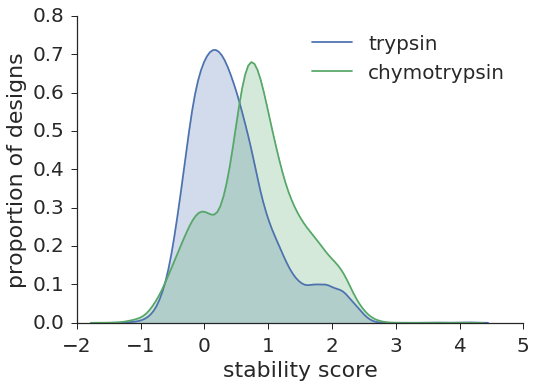

In [18]:
data = stability_scores_df[high_confidence_seqs_bools]
sns.kdeplot(data['stabilityscore_t'], label='trypsin', shade=True)
sns.kdeplot(data['stabilityscore_c'], label='chymotrypsin', shade=True)
plt.xlabel('stability score')
plt.ylabel('proportion of designs')
plt.legend()
sns.despine()
plt.show()

Plot the distribution of stability scores for designs vs. negative controls for chymotrypsin

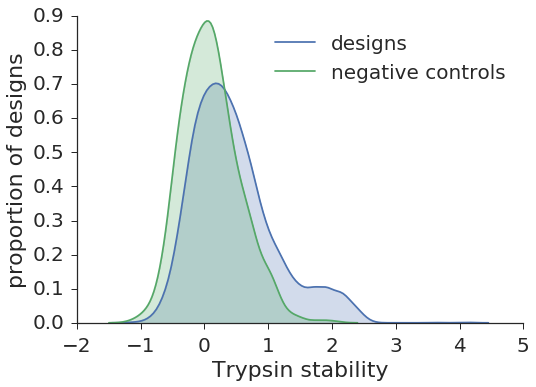

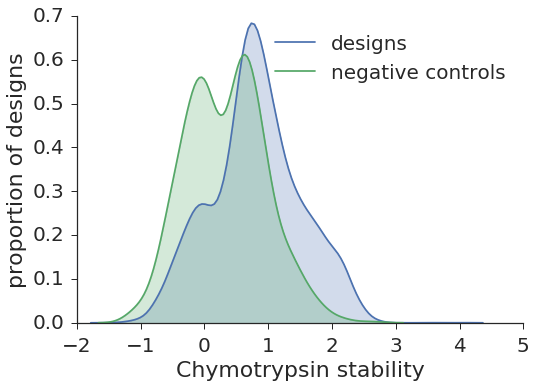

In [24]:
design_data = stability_scores_df[(high_confidence_seqs_bools) & (design_control_bools)]
negative_control_data = stability_scores_df[(high_confidence_seqs_bools) & (negative_control_bools)]
for protease in ['t', 'c']:
    sns.kdeplot(design_data['stabilityscore_{0}'.format(protease)], label='designs', shade=True)
    sns.kdeplot(negative_control_data['stabilityscore_{0}'.format(protease)], label='negative controls', shade=True)
    label_dict = {'t':'Trypsin', 'c':'Chymotrypsin'}
    plt.xlabel('{0} stability'.format(label_dict[protease]))
    plt.ylabel('proportion of designs')
    plt.legend()
    sns.despine()
    plt.show()

Look at the correlation in stability scores between proteases

0.634677963711


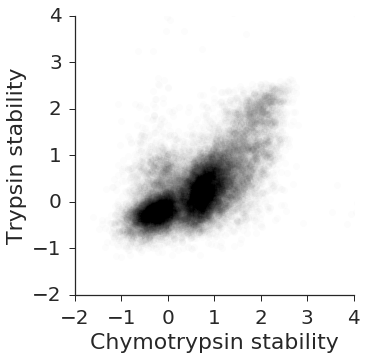

In [20]:
data = stability_scores_df[high_confidence_seqs_bools]
print(data['stabilityscore_t'].corr(data['stabilityscore_c']))
fig = plt.figure(figsize=(5,5))
sns.regplot(
    x='stabilityscore_c',
    y='stabilityscore_t',
    data=stability_scores_df,
    fit_reg=False,
    color='k',
    scatter_kws={'alpha':0.01, 's':50}
)

range_min = -2
range_max = 5
ticks = list(range(range_min, range_max))
plt.xlim([range_min, range_max-1])
plt.ylim([range_min, range_max-1])
plt.xticks(ticks)
plt.yticks(ticks)
plt.xlabel('Chymotrypsin stability')
plt.ylabel('Trypsin stability')
#plt.axis('equal')
sns.despine()
plt.show()

For the ladder of sequences from Gabe's study, compare the stability scores from this experiment and the Rocklin experiment.

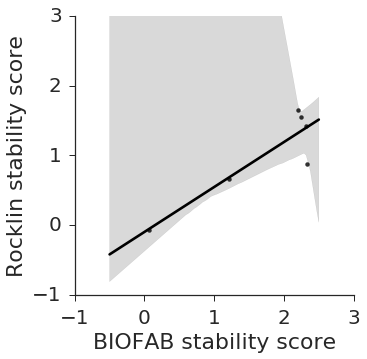

In [23]:
# Define name of ladder sequences
data = stability_scores_df[high_confidence_seqs_bools]
ladder_seq_names = [
    'EHEE_rd4_0183.pdb', 'Pin1_S18G', 'Pin1', 'Pin1_T29D',
    'Pin1_W11F', 'HHH_0972.pdb'
]
ladder_seq_names_found = []
for seq_name in ladder_seq_names:
    if seq_name in data.index.values:
        ladder_seq_names_found.append(seq_name)
    else:
        print("Could not find data for the ladder sequence named: {0}".format(seq_name))
ladder_df = stability_scores_df.loc[ladder_seq_names_found]
ladder_df.set_index('protein_sequence_c', inplace=True, drop=False)

# Get sequences of ladder sequences, as some names aren't present
# in Roclin data
ladder_seqs = ladder_df.index.values

# Read in the Rocklin scores
rocklin_stability_score_files = [
    'data/Rocklin_2017_Science/experimental_stability_scores_rd{0}.txt'.format(i)
    for i in [1, 2, 3, 4]    
] + ['data/Rocklin_2017_Science/ssm2_stability_scores']
dfs = []
for f in rocklin_stability_score_files:
    df = pandas.read_csv(f, sep='\t')
    dfs.append(df)
rocklin_stability_scores_df = pandas.concat(dfs)
rocklin_stability_scores_df.set_index('sequence', inplace=True)

# Get stabilities from the Rocklin data
stability_scores_final = []
stability_scores_final_c = []
for seq in ladder_seqs:
    stability_scores = rocklin_stability_scores_df.loc[seq][['consensus_stability_score', 'stabilityscore']]
    stability_scores.dropna(inplace=True)
    assert len(list(stability_scores)) == 1
    stability_scores_final.append(stability_scores[0])
ladder_df['rockin_stabilityscore'] = stability_scores_final

# Plot the correlation between our estimates and the Rocklin estimates
fig = plt.figure(figsize=[5,5])
sns.regplot(
    x='stabilityscore_c',
    y='rockin_stabilityscore',
    data=ladder_df,
    color='k'
)
sns.despine()
ticks = list(range(-1,4))
plt.xlabel('BIOFAB stability score')
plt.ylabel('Rocklin stability score')
plt.xticks(ticks)
plt.yticks(ticks)
plt.xlim([ticks[0], ticks[-1]])
plt.ylim([ticks[0], ticks[-1]])
plt.show()

In [ ]:
print(stability_scores_df['stabilityscore_t'].corr(stability_scores_df['stabilityscore_c']))
sns.lmplot(x='stabilityscore_t', y='stabilityscore_c', data=stability_scores_df)

Look at the distribution of stability scores for trypsin and chymotrypsin.

In [ ]:
sns.distplot(stability_scores_df['stabilityscore_t'], label='trypsin')
sns.distplot(stability_scores_df['stabilityscore_c'], label='chymotrypsin')
plt.ylabel('proportion of designs')
plt.xlabel('stability')
plt.legend()
plt.show()

## To do:

* Quantify sequencing depth
* Look at the distribution of counts over time

Quantify the number of assembled reads per sample

In [ ]:
def ParsePAREOutfile(outfile):
    """
    This function parses the output data generated by PARE when assemblying paired-end reads
    
    Args:
        `outfile`: the path to a file with the output data generated by PARE
        
    Returns:
        A tupple with the following three variables in the order they appear in the below list:
            `n_assembled_reads` : the total number of assembled reads
            `n_discarded_reads` : the total number of discarded reads
            `n_non_assembled_reads` : the total number of non_assembled_reads
    """
    
    # Pattern used to extract data
    n_reads_pattern = re.compile(r'\: (?P<n_reads>[\d,]+) /')
    
    # Use regular expressions to extract the relevant info from the file
    n_assembled_reads = n_discarded_reads = n_non_assembled_reads = n_total_reads = None
    with open(outfile) as f:
        #print(f.readlines())
        for line in f:
            if 'Assembled reads .' in line:
                if n_assembled_reads:
                    raise ValueError("Already found data for `n_assembled_reads`")
                n_assembled_match = re.search(n_reads_pattern, line)
                n_assembled_reads = int(n_assembled_match.group('n_reads').replace(',', ''))
                
            elif 'Discarded reads .' in line:
                if n_discarded_reads:
                    raise ValueError("Already found data for `n_discarded_reads`")
                n_discarded_match = re.search(n_reads_pattern, line)
                n_discarded_reads = int(n_discarded_match.group('n_reads').replace(',', ''))
                
            elif 'Not assembled reads .' in line:
                if n_non_assembled_reads:
                    raise ValueError("Already found data for `n_non_assembled_reads`")
                n_non_assembled_match = re.search(n_reads_pattern, line)
                n_non_assembled_reads = int(n_non_assembled_match.group('n_reads').replace(',', ''))
    
    return (n_assembled_reads, n_discarded_reads, n_non_assembled_reads)


In [ ]:
# Find log files from PARE
pare_log_dir = os.path.join(resultsdir, 'paired_FASTQ_files')

selection_indices = list(range(0,7))
experiment_names = ['trypsin_{0}'.format(i) for i in selection_indices] + \
    ['chymotrypsin_{0}'.format(i) for i in selection_indices]
log_files = glob.glob(os.path.join(pare_log_dir, '*.log'))
log_files_dict = {
    experiment_name : []
    for experiment_name in experiment_names
}
# For each log file, look for an experimental name that matches the beginning
# of the base name of the log file
for log_file_name in log_files:
    matching_experiments = []
    for experiment_name in log_files_dict:
        log_file_basename = os.path.basename(log_file_name)
        if log_file_basename.find('{0}-'.format(experiment_name)) == 0:
            log_files_dict[experiment_name].append(log_file_name)
            matching_experiments.append(experiment_name)
    if len(matching_experiments) == 0:
        raise ValueError("Could not find a matching experiment for the log file: {0}".format(log_file_name))
    if len(matching_experiments) > 1:
        print(matching_experiments)
        raise ValueError("Found multiple matching experiments for the log file: {0}".format(log_file_name))
    assert len(matching_experiments) == 1

In [ ]:
# Read in depth and quality scores from the output of the `PEAR` program and store in a pandas dataframe
assembly_d = {
    key : []
    for key in ['experiment_name', 'n_assembled_reads', 'n_discarded_reads', 'n_non_assembled_reads']
}
for experiment_name in log_files_dict:
    assembly_d['experiment_name'].append(experiment_name)
    n_assembled_reads = n_discarded_reads = n_non_assembled_reads = 0
    for log_file_name in log_files_dict[experiment_name]:
        (n_assembled_reads_i, n_discarded_reads_i, n_non_assembled_reads_i) = \
            ParsePAREOutfile(log_file_name)
        n_assembled_reads += n_assembled_reads_i
        n_discarded_reads += n_discarded_reads_i
        n_non_assembled_reads += n_non_assembled_reads_i
    assembly_d['n_assembled_reads'].append(n_assembled_reads)
    assembly_d['n_discarded_reads'].append(n_discarded_reads)
    assembly_d['n_non_assembled_reads'].append(n_non_assembled_reads)

assembly_df = pandas.DataFrame.from_dict(assembly_d)

# Plot the data for each replicate as stacked bar charts
fig = plt.figure(figsize=(10,7))

# Get data for each bar
assembly_df.set_index('experiment_name', inplace=True)
labels = sorted(assembly_df.index.values)
first_bar = assembly_df.loc[labels]['n_assembled_reads']
second_bar = assembly_df.loc[labels]['n_non_assembled_reads']
third_bar = assembly_df.loc[labels]['n_discarded_reads']
assert(len(first_bar) == len(second_bar))

# Make plot
plot_indices = np.arange(len(first_bar))
width = 0.35
plt.barh(plot_indices, first_bar, label='assembled', align='center')
plt.barh(plot_indices, second_bar, left=first_bar, label='non-assembled', color='red', align='center')
plt.barh(plot_indices, third_bar, left=second_bar, label='discarded', color='purple', align='center')
plt.yticks(plot_indices, labels)
plt.xlabel('Number of reads')
plt.legend()
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
def adjust_ylim(l):
    mn, mx = l
    mn += 1.5
    mx -= .5
    return (mn, mx)
plt.ylim(adjust_ylim(plt.ylim()))
plt.yticks()

In [ ]:
import scipy.stats
import numpy as np

df_t = pandas.read_csv(os.path.join(resultsdir, 'counts/trypsin.counts'), sep=' ')
df_t.set_index('name', inplace=True)
df_c = pandas.read_csv(os.path.join(resultsdir, 'counts/trypsin.counts'), sep=' ')
df_c.set_index('name', inplace=True)
counts_df = df_t.merge(
    df_c,
    left_index=True,
    right_index=True,
    how='outer',
    suffixes =['_t', '_c'])
print(len(counts_df), len(df_t), len(df_c))
counts_df

In [ ]:
counts_data_columns = [
    'protease', 'selection_index', 'n_unique_sequences',
    'median_counts', 'median_frequency', 'entropy'
]
counts_data_dict = {
    key : []
    for key in counts_data_columns
}
selection_indices = list(range(0,7))
for protease in ['c', 't']:
    for selection_index in selection_indices:
        counts = counts_df['counts{0}_{1}'.format(selection_index, protease)].values
        total_counts = sum(counts)
        frequencies = counts / total_counts
        assert 1-sum(frequencies) < 1e-5
        
        n_unique_sequences = sum(counts > 0)
        entropy = scipy.stats.entropy(frequencies)
        median_counts = np.median(counts)
        median_frequency = np.median(frequencies)
        
        counts_data_dict['protease'].append(protease)
        counts_data_dict['selection_index'].append(selection_index)
        counts_data_dict['n_unique_sequences'].append(n_unique_sequences)
        counts_data_dict['entropy'].append(entropy)
        counts_data_dict['median_counts'].append(median_counts)
        counts_data_dict['median_frequency'].append(median_frequency)
        
counts_data_df = pandas.DataFrame.from_dict(counts_data_dict)
counts_data_df[counts_data_columns]

## Old code

Old code for making the experimental summary file through a separate script

In [ ]:
# Specify the location of FASTQ files
fastq_dir = '/work/05402/haddox/jupyter/sd2e-community/shared-q1-workshop/strcklnd/ngs_data/run_4'

# Specify the locations of directories with FCS files with part of the FACS data 
facs_dir = "/work/05402/haddox/jupyter/sd2e-community/shared-q1-workshop/strcklnd/facs_data/production_data/"
job_ids = ['Job_56649', 'Job_56497', 'Job_56243']
facs_dirs = ','.join([os.path.join(facs_dir, job_id) for job_id in job_ids])
job_ids = ','.join(job_ids)

# Specify the FACS channel name to investigate
facs_channel_name = u'FITC-A'

# Make a list of input XML files with the other part of the FACS data
xml_files = ','.join(glob.glob(
    os.path.join(facs_dir, 'sort_reports', '*/*.xml')
))

# Specify column-specific values to analyze in the metadata files.
library_name = "Inna_April_2016"
ignore_aq_item_ids = '118852'

# Specify the output metadata CSV file
output_file = os.path.join(resultsdir_parse_metadata, 'experimental_metadata_from_script.csv')

# Carry out the command
cmd = ' '.join([
    'python',
    'scripts/parse_metadata.py',
    '--fastq_dir {0}'.format(fastq_dir),
    "--job_ids {0}".format(job_ids),
    "--facs_dirs {0}".format(facs_dirs),
    "--facs_channel_name {0}".format(facs_channel_name),
    "--xml_files {0}".format(xml_files),
    "--library_name {0}".format(library_name),
    "--ignore_aq_item_ids".format(ignore_aq_item_ids),
    "--output_file {0}".format(output_file)
])

! {cmd}